In [57]:
#%% Modules
###############################################################################
import pandas as pd                                     ## Dataframes
import numpy as np                                      ## Numeric methods
from datetime import datetime as date

## Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import os, sys, importlib 

In [58]:
## Function definition (zcore)
def zscore(series):
    z = ((series - series.mean())/series.std(ddof=0))
    return(z)

In [59]:
class Partition(object):
    """ 
    Partition dataset using either supervised or unsupervised data reduction

    Inputs:
    - data: the dataset to reduce
    - groups_dict: groups of variables to perform the reduction along
    - reduction: either PCA or LDA. If LDA needs to provide a benchmark (str)
    - benchmark: Name of the variable to supervise the LDA reduction with (str)

    Outputs:
    - loadings: the loadings of the reduction (1 if only one variable)
    - partition: results of the partitioning

    Usage:
    Partition(df, gv.groups_dict, reduction='LDA', benchmark='benchmark')

    """
    __description = "Data partitioning using dimensionality reduction"
    __author = "Romain Lafarguette, IMF/MCM, rlafarguette@imf.org"

    ## Initializer
    def __init__(self, data, groups_dict, reduction='PCA',
                 benchmark=None,PLStarget=None):

        ## Parameters
        self.reduction = reduction
        self.benchmark = benchmark
        self.PLStarget = PLStarget
        ## Clean the dataset according to the type of reduction
        if self.reduction == 'LDA':
            if isinstance(self.benchmark, str):
                dc = data.dropna(subset=[self.benchmark], axis=0, how='any')
                #dc = data.dropna(axis=0, how='any').copy()
                self.data = dc.dropna(axis=1, how='any').fillna(method='ffill').copy()
            else:
                raise ValueError('Need a benchmark with supervised reduction')
        elif self.reduction == 'PCA':
            self.data = data.dropna(axis=0, how='all').dropna(axis=1,how='any').fillna(method='ffill').copy()
            
        elif self.reduction == "PLS":
            self.data = data.dropna(axis=0, how='all').dropna(axis=1,how='any').fillna(method='ffill').copy()
            
        else:
            raise ValueError('Reduction parameter misspecified')

        ## Remove constant columns (create problem in the partitioning)
        self.data = self.data.loc[:, self.data.apply(pd.Series.nunique) != 1]
        
        ## Populate the groups only with the variables available in the frame
        self.var_dict = {k:[x for x in groups_dict[k] if x in self.data.columns]
                         for k in groups_dict.keys()}

        ## Estimate the fit
        if self.reduction == 'PCA':
            self.partition_fit_group, self.loading = self.__partition_fit_PCA()

            ## For consistency with the LDA object, rename some instances
            for group in sorted(list(self.partition_fit_group.keys())):
                setattr(self.partition_fit_group[group], 'fit',
                        self.partition_fit_group[group].fit_transform)
            
        elif self.reduction == 'LDA':
            self.partition_fit_group, self.loading = self.__partition_fit_LDA()
            
        elif self.reduction == "PLS":
           self.partition_fit_group, self.loading = self.__partition_fit_PLS()

        else:
            raise ValueError('Reduction parameter misspecified')
            


        # By default, using the original data (can be customized)
        #self.partition = zscore(self.partition_data(self.data)) 

    ## Methods
    def __partition_fit_PCA(self):
        """ Run the data partitioning using Principal Component Analysis """
        groups = sorted(list(self.var_dict.keys()))
        pca_fit_group = dict()
        loadings_frame = list()
        
        for group in groups:
            var_list = self.var_dict[group]
            if len(var_list) > 1: # Run the partition
                # Partitionning
                dg = self.data.loc[:, var_list].copy()
                X = scale(dg) # Need to scale the variables before partitioning

                ## Fit the PCA
                pca_fit = PCA(n_components=1).fit(X)
                pca_fit_group[group] = pca_fit

                ## Store the loadings
                dl = pd.DataFrame(pca_fit.components_, index=['loadings'],
                                  columns=var_list).transpose()
                dl['group'] = group
                dl['variance_ratio']=pca_fit.explained_variance_ratio_[0]
                dl['variable'] = dl.index
                loadings_frame.append(dl)
                
            elif len(var_list) == 1: # Loadings are 1
                dl = pd.DataFrame(index=var_list)
                dl['loadings'] = 1
                dl['variance_ratio']=1
                dl['group'] = group
                dl['variable'] = var_list[0]
                loadings_frame.append(dl)

            else: # Empty group: no loading
                dl = pd.DataFrame(columns=['loadings', 'group', 'variable'])
                dl['loadings'] = np.nan
                dl['variance_ratio']=np.nan
                dl['group'] = group
                dl['variable'] = np.nan
                loadings_frame.append(dl)

        dloading = pd.concat(loadings_frame)

        # Return the fit method and the associated loadings                
        return((pca_fit_group, dloading))                        

    def __partition_fit_LDA(self):
        """ Run the data partitioning using Linear Discriminant Analysis """
        groups = sorted(list(self.var_dict.keys()))
        lda_fit_group = dict()
        loadings_frame = list()
        
        for group in groups:
            var_list = self.var_dict[group]
            if len(var_list) > 1: # Run the partition
                # Partitionning
                dg = self.data.loc[:, var_list].copy()
                
                X = scale(dg) # Need to scale the variables before partitioning
                y = self.data.loc[:, self.benchmark].values
                
                ## Fit the LDA using the benchmark
                lda_fit = LDA(n_components=1).fit(X, y)
                lda_fit_group[group] = lda_fit

                ## Store the loadings
                dl = pd.DataFrame(lda_fit.coef_, index=['loadings'],
                                  columns=var_list).transpose()
        
                dl['variance_ratio']=lda_fit.explained_variance_ratio_[0]
                dl['group'] = group
                dl['variable'] = dl.index
                loadings_frame.append(dl)

            elif len(var_list) == 1: # Loadings are 1
                dl = pd.DataFrame(index=var_list)
                dl['loadings'] = 1
                dl['variance_ratio']=1
                dl['group'] = group
                dl['variable'] = var_list[0]
                loadings_frame.append(dl)

            else: # Empty group: no loading
                dl = pd.DataFrame(columns=['loadings', 'group', 'variable'])
                dl['loadings'] = np.nan
                dl['variance_ratio']=np.nan
                dl['group'] = group
                dl['variable'] = np.nan
                loadings_frame.append(dl)

        dloading = pd.concat(loadings_frame)
        
        # Return the fit method and the associated loadings        
        return((lda_fit_group, dloading))        
    
    def __partition_fit_PLS(self):
        """ Run the data partitioning using Principal Component Analysis """
        groups = sorted(list(self.var_dict.keys()))
        pls_fit_group = dict()
        loadings_frame = list()
        
        for group in groups:
            var_list = self.var_dict[group]
            if len(var_list) > 1: # Run the partition
                # Partitionning
                plsdepvar=self.PLStarget[group]
                plsavlreg=[e for e in var_list if e not in self.PLStarget[group]]
                
                ## Fit the PLS
                pls = PLS_DA(plsdepvar, plsavlreg,self.data)         
                pls_fit = pls.fit
                pls_fit_group[group] = pls_fit

                ## Store the loadings
                dl = pls.summary
                dl['group'] = group
                dl['variable'] = dl.index
                loadings_frame.append(dl)
                
            elif len(var_list) == 1: # Loadings are 1
                dl = pd.DataFrame(index=var_list)
                dl['loadings'] = 1
                dl['vip']=1
                dl['group'] = group
                dl['variable'] = var_list[0]
                loadings_frame.append(dl)

            else: # Empty group: no loading
                dl = pd.DataFrame(columns=['loadings', 'group', 'variable'])
                dl['loadings'] = np.nan
                dl['vip']=np.nan
                dl['group'] = group
                dl['variable'] = np.nan
                loadings_frame.append(dl)

        dloading = pd.concat(loadings_frame)

        # Return the fit method and the associated loadings                
        return((pls_fit_group, dloading))   
    
    def partition_data(self, dataframe):
        """ Return the aggregated data """
        # From the previous step, extract the fitting for each group
        groups = sorted(list(self.var_dict.keys()))
        pfit = self.partition_fit_group # Either PCA or LDA

        ## Prepare to store the data and the loadings
        da = pd.DataFrame(index=dataframe.index)
        
        for group in groups:
            var_list = self.var_dict[group]
            if len(var_list) > 1: # Use the loadings from the partition fit
                dg = dataframe.loc[:, var_list].copy()
                
                # Scale the variables
                X = scale(dg) 
                              
                ## Generate the data using the partitioning fit
                if self.reduction=='PLS':
                    Y = scale(dataframe.loc[:, self.PLStarget[group]].copy())     
                    da[group] = pfit[group].fit_transform(X,Y)[0]                    
                else:
                    da[group] = pfit[group].transform(X)
                                    
                
            elif len(var_list) == 1: # Simply keep the variable as it is
                da[group] = dataframe.loc[:, var_list[0]]
        
            else: # Empty group
                da[group] = np.nan

        return(da)

In [60]:
data = pd.read_csv(r'C:\Users\jadfa\OneDrive\Documents\GitHub\GaRIMF\GAR\partition\data\alldatanonscaled.csv')
data['date'] = pd.date_range(start='2004-01-31', end='2021-08-31', freq='M')
data.set_index('date', inplace=True)
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [61]:
data = data[:'2019-11']

In [62]:
data

,Term,Interbank,Sov,LBPratespread,USDratespread,CDratespread,LBPdeprate,USDdeprate,EMP,Financialdoll,...,passenger outflow,Construction permits,Cement deliveries,portinflowpc,portoutflowpc,passengerinflowpc,passengeroutflowpc,Constructionpermitspc,Cementdeliveriespc,Dummy_variable2006
date,,,,,,,,,,,,,,,,,,,,,
2004-01-31,2.52,4.00,6.23,3.60,5.21,-3.15,7.55,3.41,-0.124678,0.660648,...,129296.533653,849400.862149,267932.293006,-0.192316,0.184994,0.352923,0.202067,0.169653,0.058940,0
2004-02-29,2.60,3.50,6.23,3.69,5.23,-3.03,7.43,3.37,-0.547668,0.660485,...,142375.338880,726957.789232,288217.845090,0.217461,0.699338,-0.058631,0.034067,0.180729,0.755790,0
2004-03-31,2.66,6.00,6.37,3.84,5.23,-2.86,7.26,3.32,0.796238,0.664061,...,107144.439167,712790.968052,182508.803423,0.189919,0.518380,0.546469,0.397163,0.605989,-0.033003,0
2004-04-30,2.71,3.75,5.86,3.99,4.97,-2.73,7.13,3.30,0.301791,0.667326,...,125017.667638,776099.605205,207343.194048,-0.290181,0.405922,0.742473,0.630778,0.122211,-0.336039,0
2004-05-31,2.69,4.00,5.38,4.00,5.01,-2.66,7.06,3.23,-1.463656,0.668629,...,133736.186995,613967.912496,196035.369395,-0.315968,0.264171,0.348978,0.381865,-0.307480,0.284919,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31,1.82,5.00,5.28,2.32,3.89,-3.91,8.81,6.01,-0.905691,0.717579,...,410227.619844,667586.972958,329304.698804,-0.152309,-0.047158,0.018639,0.047088,-0.047905,-0.240342,0
2019-08-31,1.82,6.00,5.55,2.29,3.81,-4.05,8.95,6.20,0.997338,0.729057,...,389753.340318,510122.507982,289055.678423,-0.180367,-0.134782,0.004105,0.025707,-0.274212,-0.261129,0
2019-09-30,1.82,25.00,5.47,1.79,3.69,-4.23,9.13,6.57,1.991244,0.750590,...,336261.453260,482604.398607,298466.654118,-0.230567,-0.118224,-0.046339,-0.035443,-0.228269,-0.235140,0


In [63]:
data.columns

Index(['Term', 'Interbank', 'Sov', 'LBPratespread', 'USDratespread',
       'CDratespread', 'LBPdeprate', 'USDdeprate', 'EMP', 'Financialdoll',
       'CA', 'FA', 'Rem', 'FApc', 'CApc', 'CAratio', 'rempc', 'Oil', 'Tadawol',
       'gdp', 'gdp3', 'gdp6', 'gdp12', 'dep_sov_spread', 'M2resratio',
       'portinflow', 'portoutflow', 'passenger inflow', 'passenger outflow',
       'Construction permits ', 'Cement deliveries', 'portinflowpc',
       'portoutflowpc', 'passengerinflowpc', 'passengeroutflowpc',
       'Constructionpermitspc', 'Cementdeliveriespc', 'Dummy_variable2006'],
      dtype='object')

In [72]:
# Variables grouping
priceofrisk_l = ['Interbank', 'CDratespread', 'LBPdeprate', 'dep_sov_spread', 'USDdeprate']
macrodomestic_l = ['Construction permits ', 'Cement deliveries', 'portinflow', 'passenger inflow']
ratepressure_l = ['Financialdoll', 'EMP', 'M2resratio']
external_l = ['Oil', 'Tadawol']
# Create a dictionary, convenient for labeling later
var_groups_d = {
    'priceofrisk': priceofrisk_l,
    'macrodomestic' : macrodomestic_l,
    'ratepressure' : ratepressure_l,
    'external' : external_l
    }

In [73]:
partition_instance = Partition(data, var_groups_d, reduction='PCA', benchmark='benchmark')

In [74]:
partitioned_data = partition_instance.partition_data(data)
print(partitioned_data)

            external  macrodomestic  priceofrisk  ratepressure
date                                                          
2004-01-31  0.812910       2.002493     1.000421      0.545327
2004-02-29  0.794679       1.710869     0.784259      0.187986
2004-03-31  1.385136       2.700241     0.669097      1.099579
2004-04-30  1.702268       2.336171     0.300671      1.040979
2004-05-31  2.067763       2.909243     0.149910     -0.197503
...              ...            ...          ...           ...
2019-07-31 -0.633585      -0.551228     4.551460      0.441210
2019-08-31 -0.761449      -0.511280     4.986199      1.483409
2019-09-30 -0.835120       0.445903     6.871285      2.278374
2019-10-31 -0.975456       0.613702     6.166806      0.657441
2019-11-30 -0.504959       1.865649     9.016809      2.254768

[191 rows x 4 columns]


In [75]:
loadings = partition_instance.loading
print(loadings)

                       loadings          group  variance_ratio  \
Oil                    0.707107       external        0.769761   
Tadawol                0.707107       external        0.769761   
Construction permits  -0.257807  macrodomestic        0.581197   
Cement deliveries     -0.545899  macrodomestic        0.581197   
portinflow            -0.596475  macrodomestic        0.581197   
passenger inflow      -0.528912  macrodomestic        0.581197   
Interbank              0.288665    priceofrisk        0.769636   
CDratespread          -0.485096    priceofrisk        0.769636   
LBPdeprate             0.491543    priceofrisk        0.769636   
dep_sov_spread        -0.483703    priceofrisk        0.769636   
USDdeprate             0.453620    priceofrisk        0.769636   
Financialdoll          0.638510   ratepressure        0.501782   
EMP                    0.332086   ratepressure        0.501782   
M2resratio             0.694279   ratepressure        0.501782   

         

In [76]:
import matplotlib.pyplot as plt                       ## Plotting
import seaborn as sns                                 ## Plotting
from matplotlib import gridspec   

In [77]:
#%% Partition plot
###############################################################################
def partition_plot(dall,ddatac,dload,group_list,PLStarget,depvar,method):
    plt.close('all')

    if method=='PLS':
        figs=[]
        for g,group in enumerate(group_list):
            fig = plt.figure(figsize=(30,20))

        ## Define the grid
            gs = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.25) 
        
        ## VIP
            ax_vip = fig.add_subplot(gs[0, 0])
            plt.sca(ax_vip)
            dload[dload['group']==group]['vip'].plot.barh(axes=ax_vip,fontsize=22)
            ax_vip.set_title('Variables Influence in the Prediction',fontsize=22)
        ## PLS
            ax_PLS = fig.add_subplot(gs[0, 1])
            plt.sca(ax_PLS)
            ddatac[group].plot(label="PLS", legend=True)
            plt.yticks(fontsize=22)
            plt.xticks(fontsize=22)
            ax_PLS.xaxis.set_label_text("")
            ax_PLS.set_title('Partition',fontsize=22)    
            plt.legend(loc=1,fontsize=22)
            
        ## Lodings
            ax_load = fig.add_subplot(gs[1, 0])
            plt.sca(ax_load)
            dload[dload['group']==group]['loadings'].plot.barh(axes=ax_load,fontsize=22)
            ax_load.set_title('Loadings',fontsize=22)
        ## Target
            ax_tar = fig.add_subplot(gs[1, 1])
            plt.sca(ax_tar)
            for e in PLStarget[group]:
                 zscore(dall[e]).plot(label=e, legend=True)
            plt.yticks(fontsize=22)
            plt.xticks(fontsize=22)
            ax_tar.xaxis.set_label_text("")
            ax_tar.set_title('Target variables(Normalized)',fontsize=20)    
            plt.legend(loc=1,fontsize=22)
        ## Title
            title ='Summary plots for '+group

            fig.suptitle(title, fontsize=28)    
        
#        fig1,ax1 = plt.subplots(1, 1, figsize=(20,40))
#        vd='vip'
#        xs=0
#        xm=max(dload[vd].values)      
#        plt.sca(ax1)
#        dload['vip'].plot.barh(axes=ax1,fontsize=30)
#        ax1.set_title('Vip of the partition',fontsize=45)
            figs.append(fig)
    else:
    
    ## Prepare the frame of original data
        group_list.sort()
        cr=len(group_list)
        fig, axes = plt.subplots(nrows= 3, ncols=len(group_list), figsize=(11*cr,45))
        
        if len(group_list)>1:
            for g, group in enumerate(group_list):
    
                group_label = group
            
            ## Upper plot
                ddatac.loc[:,group].plot(ax=axes[0,g])
                axes[0,g].axhline(y=0, c='black', linewidth=0.7)
                axes[0,g].set_title('{} over time'.format(group_label),
                                fontsize=30, y=1.05)
                axes[0,g].set_xlabel('')
                axes[0,g].tick_params(labelsize=18)
                plt.setp(axes[0,g].xaxis.get_majorticklabels(), rotation=70 )
                  
            ## Middle plot
                dl1 = dload[dload.group==group]
                dl1['loadings'] = dl1['loadings'] # Now remove absolute
                dl1 = dl1.sort_values(by=['loadings'], ascending=[0])
                sum_abs = np.sum(np.absolute(dl1.loadings))
                dl1['norm_loadings'] = dl1['loadings']/sum_abs
                x_arr = dl1.norm_loadings.values
                y_arr = np.arange(len(dl1.variable))
                axes[1,g].hlines(y_arr, 0, x_arr, color='red')  # Stems
                axes[1,g].plot(x_arr, y_arr, 'D')  # Stem ends
                axes[1,g].plot([0, 0], [y_arr.min(), y_arr.max()], '--')  # Middle bar
                axes[1,g].set_yticks(range(len(dl1.variable.values)))
                ytick=dl1.variable.values
                for ind in range(len(ytick)):
                    if len(ytick[ind])>10:
                        ytick[ind]=ytick[ind][0:7]+'...'
                axes[1,g].set_yticklabels(ytick)
                axes[1,g].set_title('Loadings: {}'.format(group_label), fontsize=30)
                axes[1,g].tick_params(labelsize=25)
            ## Increase size to avoid chart to disappear
                ymin, ymax = axes[1,g].get_ylim()
                axes[1,g].set_ylim([ymin-0.5,ymax+0.5])
                
                
            ## Buttom plot
                x_arr = [abs(e) for e in dl1.norm_loadings.values]
                y_arr = np.arange(len(dl1.variable))
                axes[2,g].hlines(y_arr, 0, x_arr, color='red')  # Stems
                axes[2,g].plot(x_arr, y_arr, 'D')  # Stem ends
                axes[2,g].plot([0, 0], [y_arr.min(), y_arr.max()], '--')  # Middle bar
                axes[2,g].set_yticks(range(len(dl1.variable.values)))
                ytick=dl1.variable.values
                for ind in range(len(ytick)):
                    if len(ytick[ind])>10:
                        ytick[ind]=ytick[ind][0:7]+'...'
                axes[2,g].set_yticklabels(ytick)
                axes[2,g].set_title('ABS Loadings: {}'.format(group_label), fontsize=30)
                axes[2,g].tick_params(labelsize=25)
            ## Increase size to avoid chart to disappear
                ymin, ymax = axes[1,g].get_ylim()
                axes[2,g].set_ylim([ymin-0.5,ymax+0.5])
        elif len(group_list)==1:
                group=group_list[0]
                group_label = group
            
            ## Upper plot
                ddatac.loc[:,group].plot(ax=axes[0])
                axes[0].axhline(y=0, c='black', linewidth=0.7)
                axes[0].set_title('{} over time'.format(group_label),
                                fontsize=30, y=1.05)
                axes[0].set_xlabel('')
                axes[0].tick_params(labelsize=18)
                plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=70 )
                  
            ## Middle plot
                dl1 = dload[dload.group==group]
                dl1['loadings'] = dl1['loadings'] # Now remove absolute
                dl1 = dl1.sort_values(by=['loadings'], ascending=[0])
                sum_abs = np.sum(np.absolute(dl1.loadings))
                dl1['norm_loadings'] = dl1['loadings']/sum_abs
                x_arr = dl1.norm_loadings.values
                y_arr = np.arange(len(dl1.variable))
                axes[1].hlines(y_arr, 0, x_arr, color='red')  # Stems
                axes[1].plot(x_arr, y_arr, 'D')  # Stem ends
                axes[1].plot([0, 0], [y_arr.min(), y_arr.max()], '--')  # Middle bar
                axes[1].set_yticks(range(len(dl1.variable.values)))
                ytick=dl1.variable.values
                for ind in range(len(ytick)):
                    if len(ytick[ind])>10:
                        ytick[ind]=ytick[ind][0:7]+'...'
                axes[1].set_yticklabels(ytick)
                axes[1].set_title('Loadings: {}'.format(group_label), fontsize=30)
                axes[1].tick_params(labelsize=25)
            ## Increase size to avoid chart to disappear
                ymin, ymax = axes[1].get_ylim()
                axes[1].set_ylim([ymin-0.5,ymax+0.5])
                
                x_arr = [abs(e) for e in dl1.norm_loadings.values]
                y_arr = np.arange(len(dl1.variable))
                axes[2].hlines(y_arr, 0, x_arr, color='red')  # Stems
                axes[2].plot(x_arr, y_arr, 'D')  # Stem ends
                axes[2].plot([0, 0], [y_arr.min(), y_arr.max()], '--')  # Middle bar
                axes[2].set_yticks(range(len(dl1.variable.values)))
                ytick=dl1.variable.values
                for ind in range(len(ytick)):
                    if len(ytick[ind])>10:
                        ytick[ind]=ytick[ind][0:7]+'...'
                axes[2].set_yticklabels(ytick)
                axes[2].set_title('ABS Loadings: {}'.format(group_label), fontsize=30)
                axes[2].tick_params(labelsize=25)
            ## Increase size to avoid chart to disappear
                ymin, ymax = axes[1].get_ylim()
                axes[2].set_ylim([ymin-0.5,ymax+0.5])
            
            
    
            
    #        ## Correlation plot
    #
    #        ddg= ddatac.dropna(subset=[group], axis=0).copy()
    #        ddg = ddg.set_index(ddg.date)
    #        ddg.loc[:,[depvar, group]].plot(ax=axes[2,g], secondary_y=[group])
    #
    #        axes[2,g].set_title('Correlation with dependent variable : {0}'.format(group_label),
    #                            fontsize=30, y=1.05)
    #        axes[2,g].tick_params(labelsize=18)
    #        axes[2,g].legend(loc='upper center', prop={'size':15})
    #        axes[2,g].set_xlabel('')
    #        plt.setp(axes[2,g].xaxis.get_majorticklabels(), rotation=70 )
        
        fig.subplots_adjust(hspace=0.55, wspace=0.55)
        if method!='PCA':
            fig.suptitle('Supervised data partitioning normalized loadings',
                         y=0.95,fontsize=45)
        else:
            fig.suptitle('Unsupervised data partitioning normalized loadings',
                         y=0.95,fontsize=45)
        #plt.show()
        
        
        gvar={}
    
        fig1,ax1 = plt.subplots(1, 1, figsize=(15,30))
        vd='variance_ratio'
        xs=0
        xm=1.2
        ytick=group_list
        for group in group_list:
            gvar[group]=dload[dload['group']==group][vd].values[0]
        x_arr=[gvar[g] for g in group_list]
        y_arr=np.arange(len(group_list))

        ax1.hlines(y_arr, xs, x_arr, color='red')  # Stems
    #ax1.plot([1, 1], [y_arr.min(), y_arr.max()], '--')
        ax1.set_yticks(range(len(group_list)))
        
        ax1.set_yticklabels(ytick)
        ax1.set_xticks(np.arange(xs,xm,0.2))
        ax1.set_title(vd+' of the partition',fontsize=45)
        ax1.tick_params(labelsize=36)
        ymin, ymax = ax1.get_ylim()
        ax1.set_ylim([ymin-0.5,ymax+0.5])
        ax1.grid()
        figs=[fig,fig1]
    return figs

In [78]:
group_list = sorted(var_groups_d.keys())

C:\Users\jadfa\AppData\Local\Temp\ipykernel_28096\1187228598.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dl1['loadings'] = dl1['loadings'] # Now remove absolute
C:\Users\jadfa\AppData\Local\Temp\ipykernel_28096\1187228598.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dl1['loadings'] = dl1['loadings'] # Now remove absolute
C:\Users\jadfa\AppData\Local\Temp\ipykernel_28096\1187228598.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

[<Figure size 4400x4500 with 12 Axes>, <Figure size 1500x3000 with 1 Axes>]

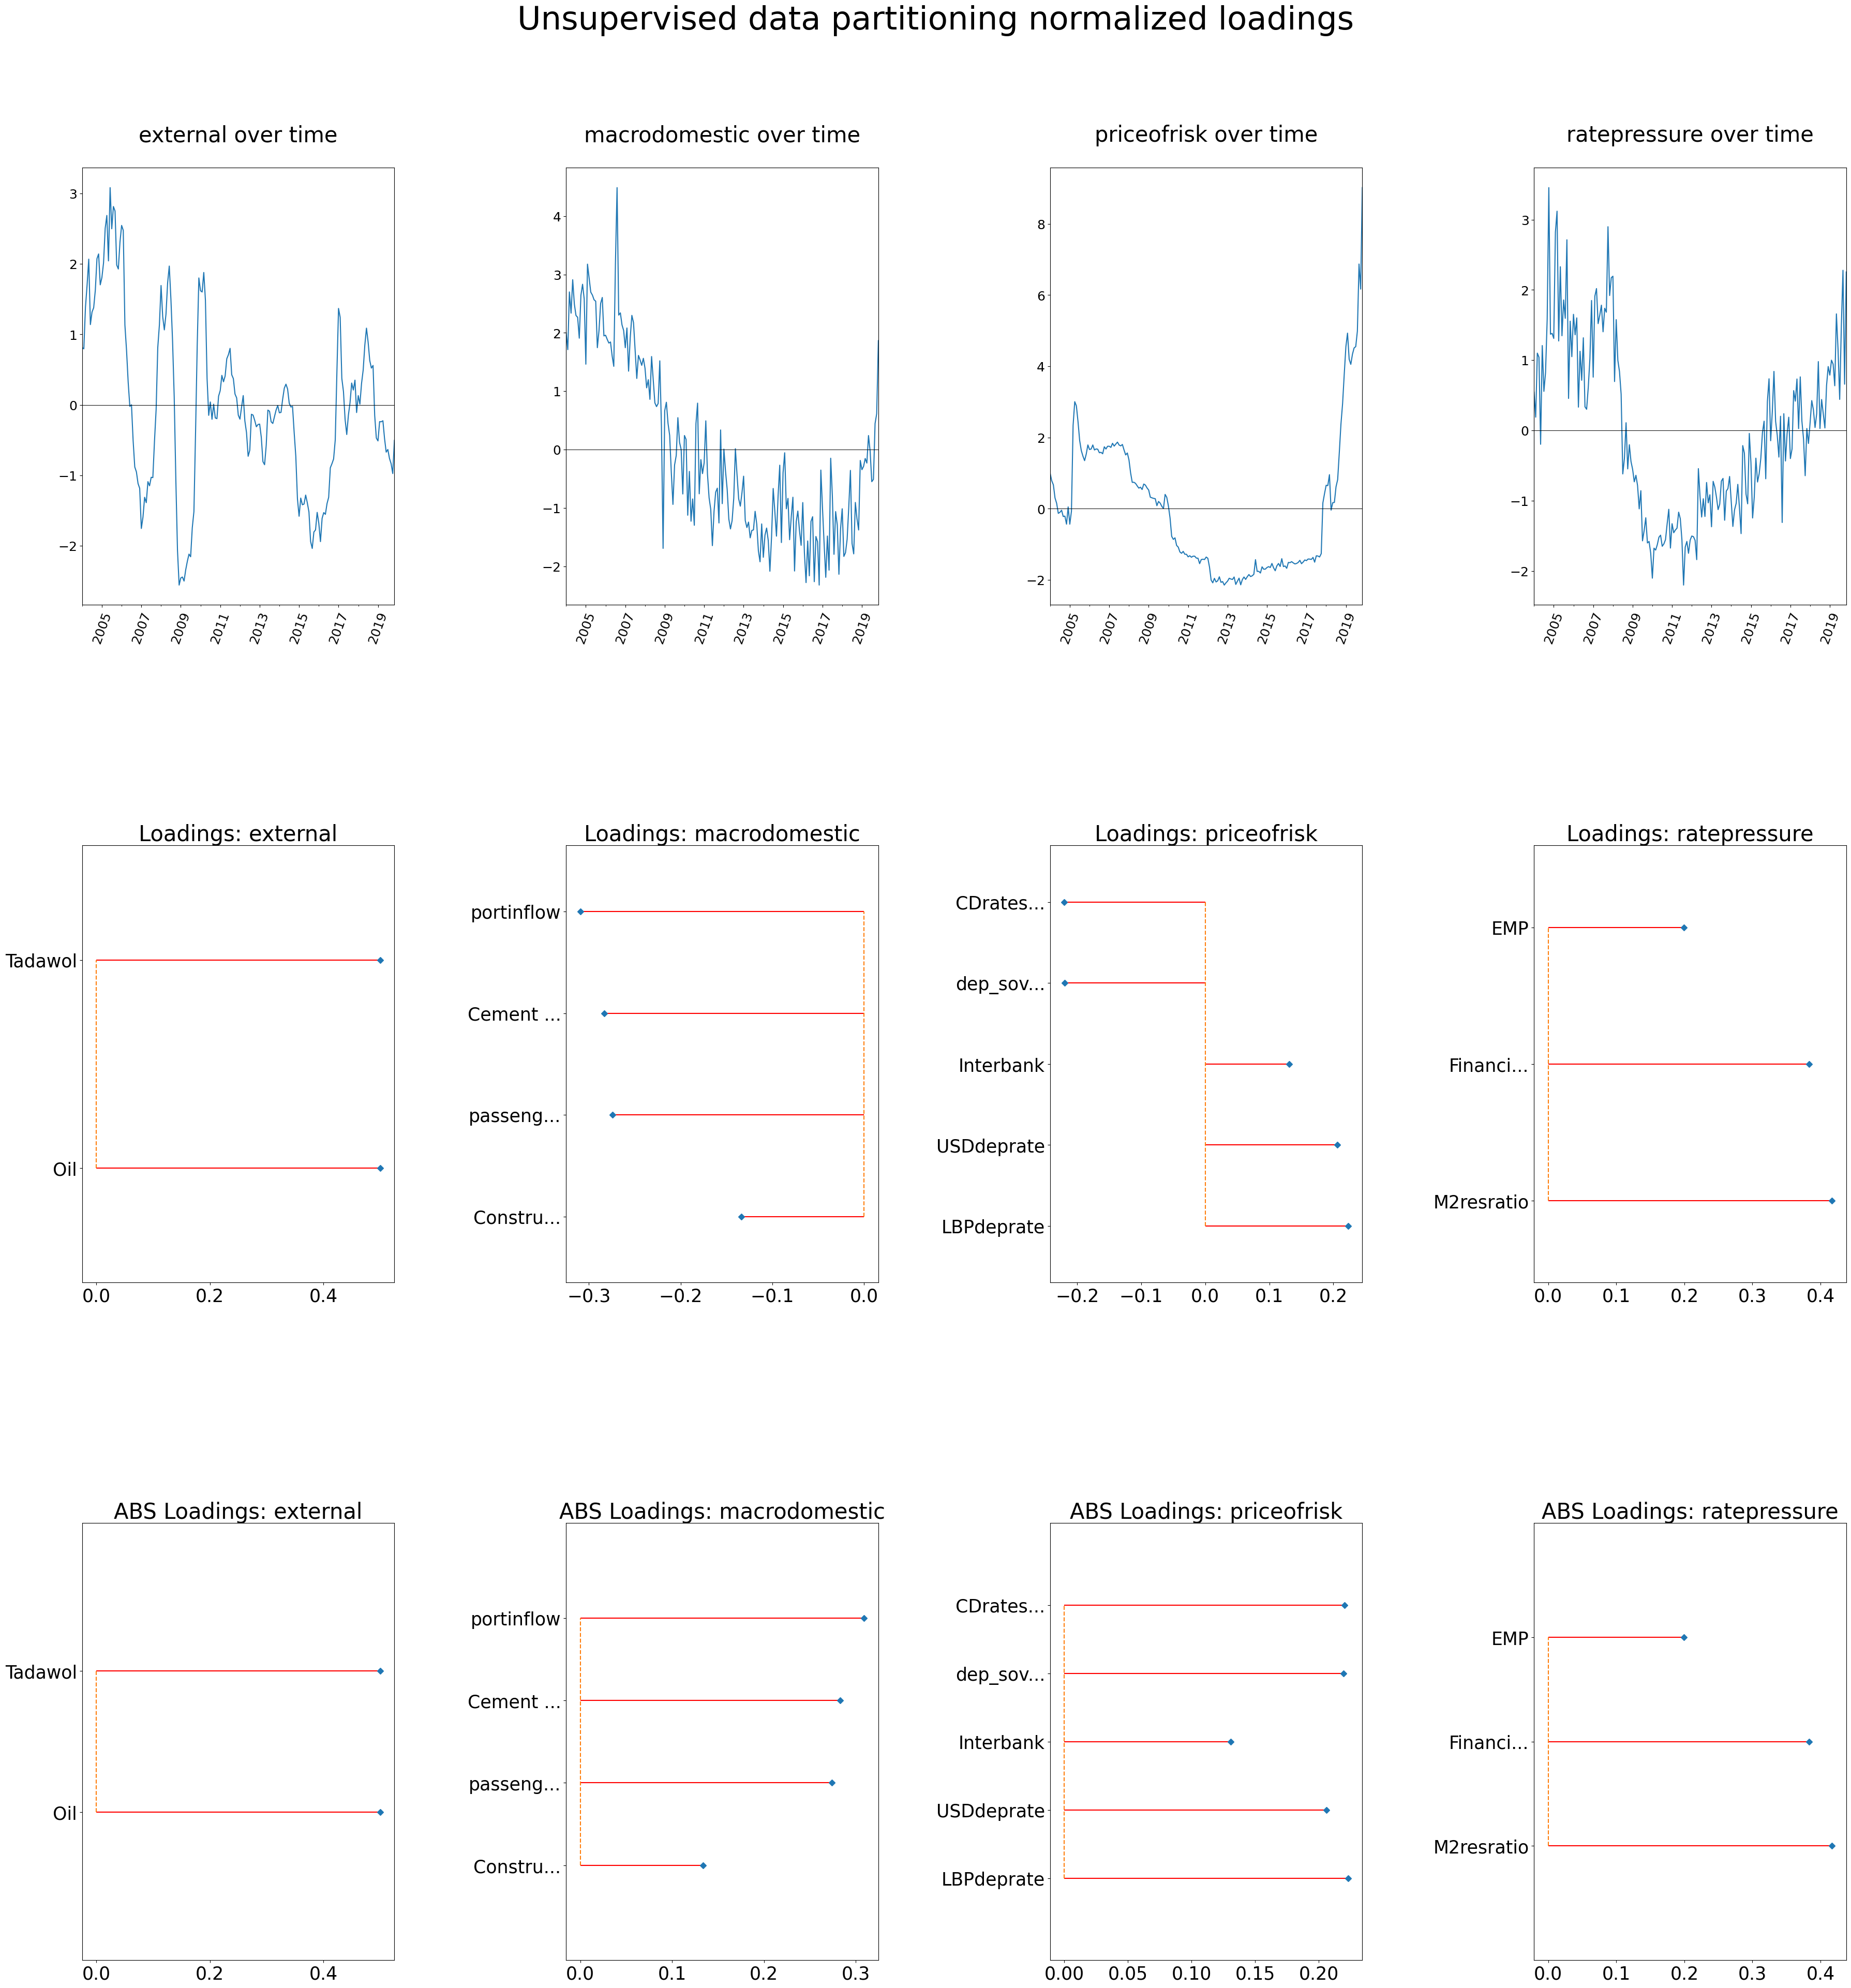

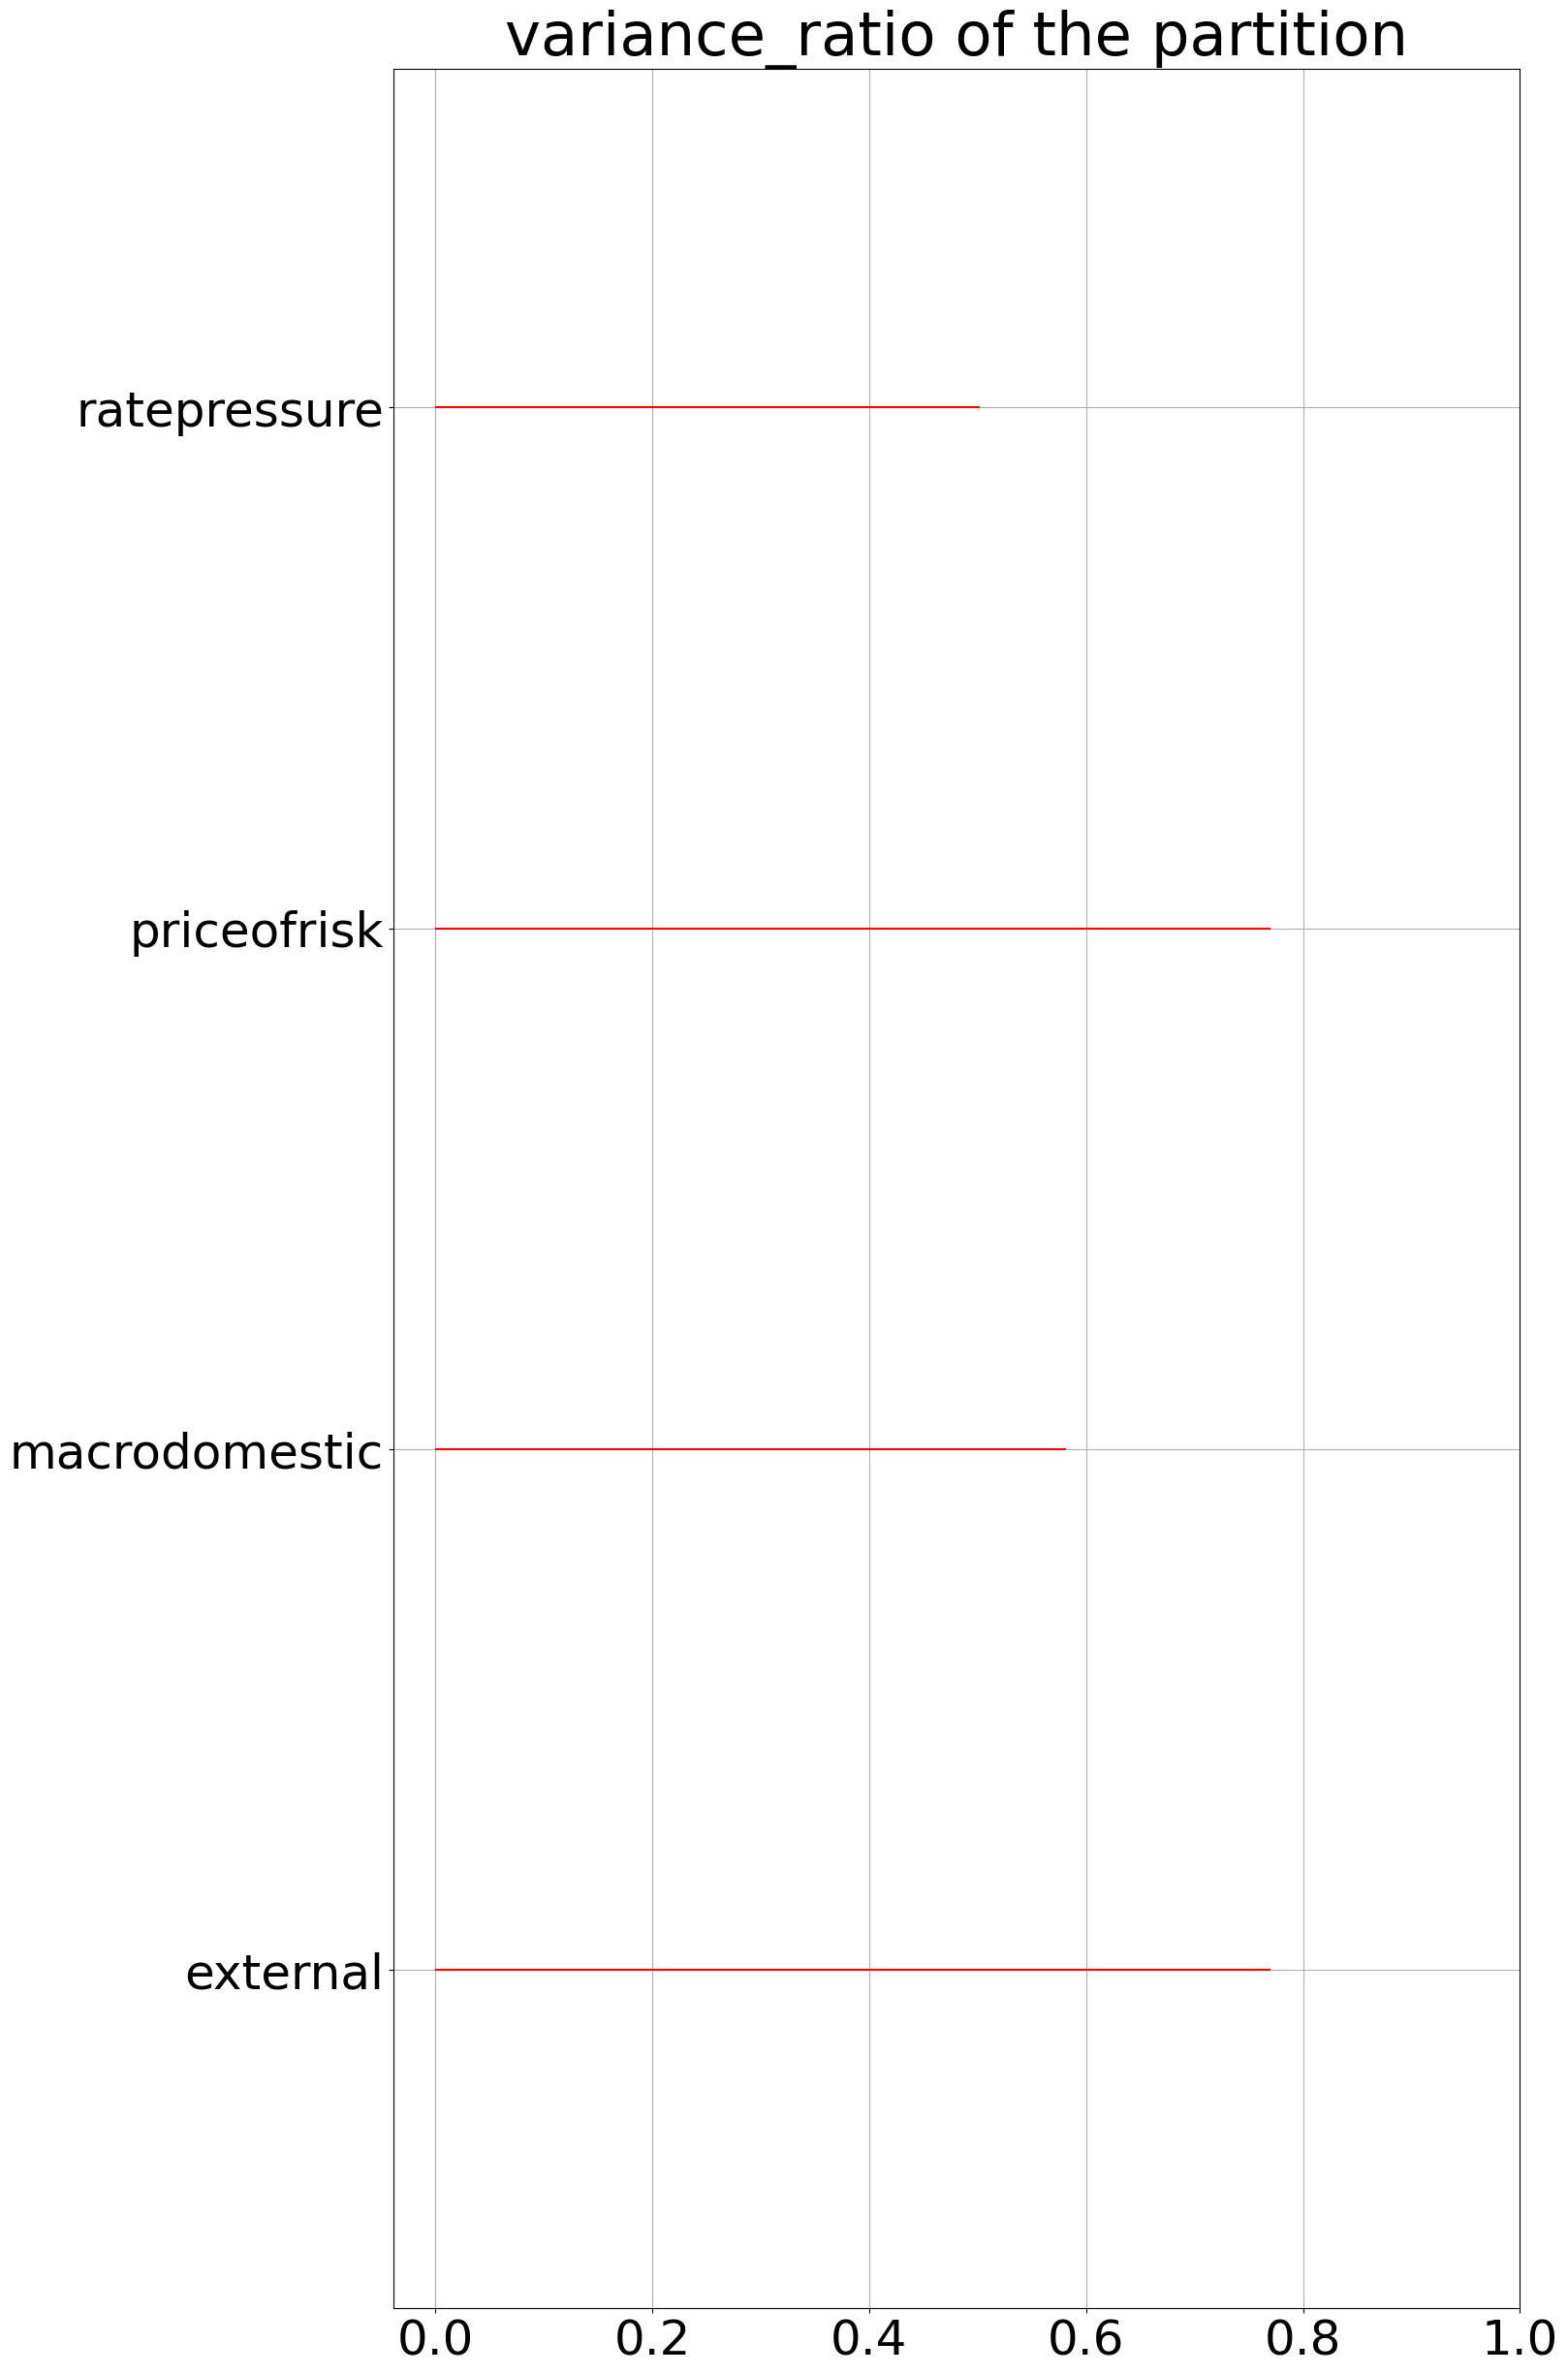

In [79]:
partition_plot(data, partitioned_data, loadings , group_list, data['Term'], data['gdp'], 'PCA')

In [80]:
os.makedirs('Data', exist_ok=True)  
partitioned_data.to_csv('Data/FCIdatamonth.19.csv')